# Text Classification:

## Data
<pre>
1. we have total of 20 types of documents(Text files) and total 18828 documents(text files).
2. You can download data from this <a href='https://drive.google.com/open?id=1rxD15nyeIPIAZ-J2VYPrDRZI66-TBWvM'>link</a>, in that you will get documents.rar folder. <br>If you unzip that, you will get total of 18828 documnets. document name is defined as'ClassLabel_DocumentNumberInThatLabel'. 
so from document name, you can extract the label for that document.
4. Now our problem is to classify all the documents into any one of the class.
5. Below we provided count plot of all the labels in our data. 
</pre>

In [ ]:
import sklearn
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from colorama import Fore, Back, Style
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import keras_tuner
from keras_tuner import *
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os 
import background
from time import sleep
from sklearn.metrics import classification_report

In [ ]:
os.chdir("/home/ubuntu/aaic/CNN_with_textdata/documents")

In [ ]:
files=os.listdir()

In [ ]:
files.sort()

In [ ]:
y = []
for i in files:
    y.append(i.split("_")[0])

<AxesSubplot:xlabel='count'>

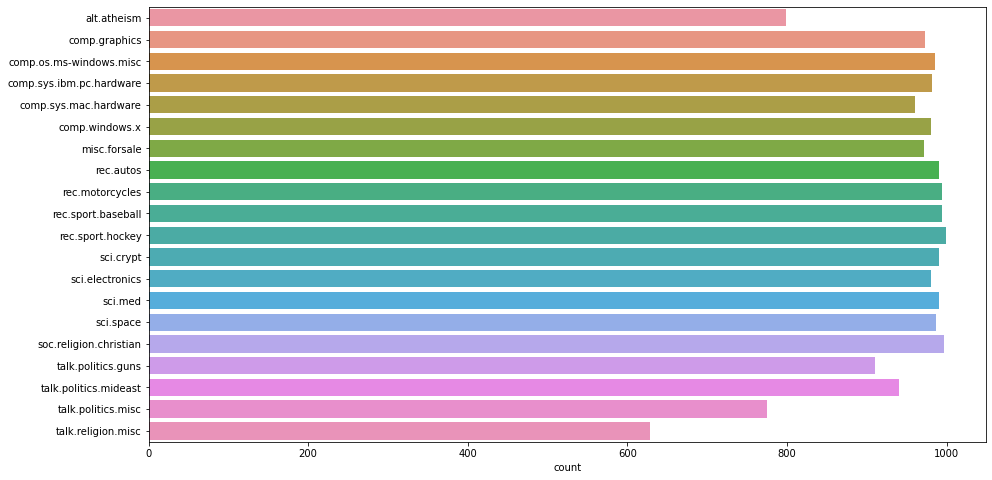

In [ ]:
### count plot of all the class labels.
plt.figure(figsize=(15, 8))
sns.countplot(y=y)

In [ ]:
#reading data from harddisk and storing as x labels 
x = []
for i in tqdm(range(len(files))):
    x.append(open(files[i], errors="ignore").read())

  0%|          | 0/18828 [00:00<?, ?it/s]

#### sample document
<pre>
<font color='blue'>
Subject: A word of advice
From: jcopelan@nyx.cs.du.edu (The One and Only)

In article < 65882@mimsy.umd.edu > mangoe@cs.umd.edu (Charley Wingate) writes:
>
>I've said 100 times that there is no "alternative" that should think you
>might have caught on by now.  And there is no "alternative", but the point
>is, "rationality" isn't an alternative either.  The problems of metaphysical
>and religious knowledge are unsolvable-- or I should say, humans cannot
>solve them.

How does that saying go: Those who say it can't be done shouldn't interrupt
those who are doing it.

Jim
--
Have you washed your brain today?
</font>
</pre>

### Preprocessing:
<pre>
useful links: <a href='http://www.pyregex.com/'>http://www.pyregex.com/</a>

<font color='blue'><b>1.</b></font> Find all emails in the document and then get the text after the "@". and then split those texts by '.' 
after that remove the words whose length is less than or equal to 2 and also remove'com' word and then combine those words by space. 
In one doc, if we have 2 or more mails, get all.
<b>Eg:[test@dm1.d.com, test2@dm2.dm3.com]-->[dm1.d.com, dm3.dm4.com]-->[dm1,d,com,dm2,dm3,com]-->[dm1,dm2,dm3]-->"dm1 dm2 dm3" </b> 
append all those into one list/array. ( This will give length of 18828 sentences i.e one list for each of the document). 
Some sample output was shown below. 

> In the above sample document there are emails [jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu]

preprocessing:
[jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu] ==> [nyx cs du edu mimsy umd edu cs umd edu] ==> 
[nyx edu mimsy umd edu umd edu]

<font color='blue'><b>2.</b></font> Replace all the emails by space in the original text. 
</pre>

In [ ]:
preprocessed_email = []
for i in range(len(x)):
    a = re.findall("[0-9a-zA-z_+\-.]+@[0-9a-zA-z_.\-+]+", x[i])
    for j in range(len(a)):
        a[j]=re.sub('.*@','',a[j])
    u=(" ".join(re.split("[@.]", ".".join(a))))
    preprocessed_email.append(re.sub('(?i)\scom\s|^com\s|\scom$',' ',' '.join(re.findall('[^\s][^\s][^\s][^\s]*',u)))) #removing com and below 2 or less characters
    x[i]=re.sub("[0-9a-zA-z_+\-.]+@[0-9a-zA-z_.\-+]+", "",x[i]) # deleting mails from the original data

In [ ]:
# we have collected all emails and preprocessed them, this is sample output
preprocessed_email[:10]

['mantis netcom mantis',
 'mantis mantis mantis',
 'dbstu1 tu-bs mimsy umd edu umd edu',
 'mantis kepler unh edu',
 'Watson Ibm harder ccr-p ida org harder ccr-p ida org watson ibm ',
 'dbstu1 tu-bs batman bmd trw batman bmd trw ',
 'cco caltech edu jyusenkyou jhu edu',
 'dbstu1 tu-bs edu buphy edu',
 'cco caltech edu solntze wpd sgi ',
 'cco caltech edu CWRU edu']

In [ ]:
len(preprocessed_email)

18828

<pre>
<font color='blue'><b>3.</b></font> Get subject of the text i.e. get the total lines where "Subject:" occur and remove 
the word which are before the ":" remove the newlines, tabs, punctuations, any special chars.
<b>Eg: if we have sentance like "Subject: Re: Gospel Dating @ \r\r\n" --> You have to get "Gospel Dating"</b> 
Save all this data into another list/array. 

<font color='blue'><b>4.</b></font> After you store it in the list, Replace those sentances in original text by space.

<font color='blue'><b>5.</b></font> Delete all the sentances where sentence starts with <b>"Write to:"</b> or <b>"From:"</b>.
> In the above sample document check the 2nd line, we should remove that

<font color='blue'><b>6.</b></font> Delete all the tags like "< anyword >"
> In the above sample document check the 4nd line, we should remove that "< 65882@mimsy.umd.edu >"


<font color='blue'><b>7.</b></font> Delete all the data which are present in the brackets. 
In many text data, we observed that, they maintained the explanation of sentence 
or translation of sentence to another language in brackets so remove all those.
<b>Eg: "AAIC-The course that gets you HIRED(AAIC - Der Kurs, der Sie anstellt)" --> "AAIC-The course that gets you HIRED"</b>

> In the above sample document check the 4nd line, we should remove that "(Charley Wingate)"


<font color='blue'><b>8.</b></font> Remove all the newlines('\n'), tabs('\t'), "-", "\".

<font color='blue'><b>9.</b></font> Remove all the words which ends with <b>":"</b>.
<b>Eg: "Anyword:"</b>
> In the above sample document check the 4nd line, we should remove that "writes:"


<font color='blue'><b>10.</b></font> Decontractions, replace words like below to full words. 
please check the donors choose preprocessing for this 
<b>Eg: can't -> can not, 's -> is, i've -> i have, i'm -> i am, you're -> you are, i'll --> i will </b>

<b> There is no order to do point 6 to 10. but you have to get final output correctly</b>

<font color='blue'><b>11.</b></font> Do chunking on the text you have after above preprocessing. 
Text chunking, also referred to as shallow parsing, is a task that 
follows Part-Of-Speech Tagging and that adds more structure to the sentence.
So it combines the some phrases, named entities into single word.
So after that combine all those phrases/named entities by separating <b>"_"</b>. 
And remove the phrases/named entities if that is a "Person". 
You can use <b>nltk.ne_chunk</b> to get these. 
Below we have given one example. please go through it. 

useful links: 
<a href='https://www.nltk.org/book/ch07.html'>https://www.nltk.org/book/ch07.html</a>
<a href='https://stackoverflow.com/a/31837224/4084039'>https://stackoverflow.com/a/31837224/4084039</a>
<a href='http://www.nltk.org/howto/tree.html'>http://www.nltk.org/howto/tree.html</a>
<a href='https://stackoverflow.com/a/44294377/4084039'>https://stackoverflow.com/a/44294377/4084039</a>
</pre>

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
subject=[]
for i in range(len(x)):
    c=re.findall('Subject:.*|Subject: Re:.*',x[i])
    if len(c)>=1:  #if there is subject in that document 
        c=c[0].split(':')[-1]
    else: #if there is no subject in that document 
        c=""
    subject.append(re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','',c).strip())
    x[i]=(re.sub('Subject:.*|Subject: Re:.*',' ',x[i]))  #removing subject from original document
    x[i]=(re.sub('Write to:.*|From:.*','',x[i],flags=re.IGNORECASE)) #remove to and from address from original document
    x[i]=re.sub("<.*\n*.*>",'',x[i]) #remove all b/w <.....> bracket
    x[i]=re.sub("\(.*\n*.*\)",'',x[i]) #removing all b/w (.....) bracket
    x[i]=re.sub(r"[\n\t\-]",'',x[i]).replace("\\",'') #removing ('\n'), "-", "\"
    x[i]=re.sub(r'\s+',' ',x[i]).strip() #removing extra tabs 
    x[i]=re.sub(r'[\w]*:(\s+|$)','',x[i]) #removing words which ends with :
    x[i]=decontracted(x[i])

<pre>We did chunking for above two lines and then We got one list where each word is mapped to a 
POS(parts of speech) and also if you see "New York" and "Srikanth Varma", 
they got combined and represented as a tree and "New York" was referred as "GPE" and "Srikanth Varma" was referred as "PERSON". 
so now you have to Combine the "New York" with <b>"_"</b> i.e "New_York"
and remove the "Srikanth Varma" from the above sentence because it is a person.</pre>

In [ ]:
for document_id in tqdm(range(len(x))):
    chunks=[]
    chunks=list(nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x[document_id]))))
    for i in chunks:
        if type(i)==nltk.Tree:
            if i.label() == "GPE":
                words_to_merge = i.leaves()
                if len(words_to_merge)>1:   
                    word_after_merged = "_".join([word1 for word1,word_tree in words_to_merge])
                    x[document_id] = re.sub(rf'{words_to_merge[1][0]}',word_after_merged,x[document_id], flags=re.MULTILINE) #replacing new with new_york
                    x[document_id] = re.sub(rf'\b{words_to_merge[0][0]}\b',"",x[document_id], flags=re.MULTILINE)       #deleting "new" word
            if i.label()=="PERSON":           # deleting person names  
                for term,pog in i.leaves():
                    x[document_id] = re.sub(re.escape(term),"",x[document_id], flags=re.MULTILINE)

  0%|          | 0/18828 [00:00<?, ?it/s]

In [ ]:
for document_id in tqdm(range(len(x))):
    x[document_id] = re.sub(r"\b_([a-zA-z]+)_\b",r"\1",x[document_id]) #replace _word_ to word 
    x[document_id] = re.sub(r"\b_([a-zA-z]+)\b",r"\1",x[document_id]) #replace_word to word
    x[document_id] = re.sub(r"\b([a-zA-z]+)_\b",r"\1",x[document_id]) #replace word_ to word
    x[document_id]=re.sub(r'\b[\w]{1,2}_([\w]*)',r'\1',x[document_id]) #remove sr from sr_srikar
    x[document_id]=re.sub(r'([\w]*)_[\w]{1,2}\b',r'\1',x[document_id]) #remove sr from srikar_sr
    x[document_id]=x[document_id].lower()
    x[document_id]=re.sub('[\w]{15,}','',x[document_id]) #remove words which are more than 15 
    x[document_id]=re.sub(r"\b[\w]{1,2}\b",'',x[document_id]) #removing words which are less than 3
    x[document_id]=re.sub(r'[^a-zA-Z_]',' ',x[document_id]) # replace all the words except "A-Za-z_" with space
    x[document_id]=re.sub(r'\s+',' ',x[document_id]).strip() #remove extra tabs in the text

  0%|          | 0/18828 [00:00<?, ?it/s]

<pre>
<font color='blue'><b>13.</b></font> Replace all the digits with space i.e delete all the digits. 
> In the above sample document, the 6th line have digit 100, so we have to remove that.

<font color='blue'><b>14.</b></font> After doing above points, we observed there might be few word's like
 <b> "_word_" (i.e starting and ending with the _), "_word" (i.e starting with the _),
  "word_" (i.e ending with the _)</b> remove the <b>_</b> from these type of words. 

<font color='blue'><b>15.</b></font>  We also observed some words like <b> "OneLetter_word"- eg: d_berlin, 
"TwoLetters_word" - eg: dr_berlin </b>, in these words we remove the "OneLetter_" (d_berlin ==> berlin) and 
"TwoLetters_" (de_berlin ==> berlin). i.e remove the words 
which are length less than or equal to 2 after spliiting those words by "_". 

<font color='blue'><b>16.</b></font> Convert all the words into lower case and lowe case 
and remove the words which are greater than or equal to 15 or less than or equal to 2.

<font color='blue'><b>17.</b></font> replace all the words except "A-Za-z_" with space. 

<font color='blue'><b>18.</b></font> Now You got Preprocessed Text, email, subject. create a dataframe with those. 
Below are the columns of the df. 
</pre>

In [ ]:
data=pd.DataFrame({'email':preprocessed_email,'subject':subject,"text":x,"class":y})

In [ ]:
data

,email,subject,text,class
0,mantis netcom mantis,Atheist Resources,atheism december atheist resources addresses a...,alt.atheism
1,mantis mantis mantis,Introduction to Atheism,atheism april egin pgp signed message introduc...,alt.atheism
2,dbstu1 tu-bs mimsy umd edu umd edu,Gospel Dating,article well has quite different not necessari...,alt.atheism
3,mantis kepler unh edu,university violating separation of churchstate,writes recently ras have been ordered post rel...,alt.atheism
4,Watson Ibm harder ccr-p ida org harder ccr-p i...,socmotss et al Princeton axes matching funds f...,article however hate economic terrorism and po...,alt.atheism
...,...,...,...,...
18823,fraser sfu magnus acs ohio-state edu,Religion and marriage,writes was not sure this was the right newsgro...,talk.religion.misc
18824,gtephx UUCP ifi uio ifi uio ncratl AtlantaGA N...,How do you know what happened,article writes probably not but then not pack ...,talk.religion.misc
18825,quack kfu emx utexas edu emx utexas edu,Why did they behave as they did Wacoreading su...,article writes you would like understand bette...,talk.religion.misc
18826,CUNYVM BITNET digi lonestar org digi lonestar org,Info about New Age,article the danger anticult groups that while ...,talk.religion.misc


In [ ]:
data.columns

Index(['email', 'subject', 'text', 'class'], dtype='object')

In [ ]:
data.iloc[400]

email      dsinc darkside osrhe uoknor edu okcforum osrhe...
subject                                        Biblical Rape
text       this response originally fell into bit bucket ...
class                                            alt.atheism
Name: 400, dtype: object

### Writing  total Preprocessing steps in One Function Named Preprocess  below. 

In [ ]:
def preprocess(Input_Text):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    preprocessed_email = []
    subject=[]
    chunks=[]
    x=Input_Text
    for document_id in tqdm(range(len(x))):
        a = re.findall("[0-9a-zA-z_+\-.]+@[0-9a-zA-z_.\-+]+", x[document_id])
        for j in range(len(a)):
            a[j]=re.sub('.*@','',a[j])
        u=(" ".join(re.split("[@.]", ".".join(a))))
        preprocessed_email.append(re.sub('(?i)\scom\s|^com\s|\scom$',' ',' '.join(re.findall('[^\s][^\s][^\s][^\s]*',u)))) #removing com and below 2 or less characters
        x[document_id]=re.sub("[0-9a-zA-z_+\-.]+@[0-9a-zA-z_.\-+]+", "",x[document_id]) # deleting mails from the original data

        c=re.findall('Subject:.*|Subject: Re:.*',x[document_id])
        if len(c)>=1:  #if there is subject in that document 
            c=c[0].split(':')[-1]
        else: #if there is no subject in that document 
            c=""
        subject.append(re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','',c).strip())
        x[document_id]=(re.sub('Subject:.*|Subject: Re:.*',' ',x[document_id]))  #removing subject from original document
        x[document_id]=(re.sub('Write to:.*|From:.*','',x[document_id],flags=re.IGNORECASE)) #remove to and from address from original document
        x[document_id]=re.sub("<.*\n*.*>",'',x[document_id]) #remove all b/w <.....> bracket
        x[document_id]=re.sub("\(.*\n*.*\)",'',x[document_id]) #removing all b/w (.....) bracket
        x[document_id]=re.sub(r"[\n\t\-]",'',x[document_id]).replace("\\",'') #removing ('\n'), "-", "\"
        x[document_id]=re.sub(r'\s+',' ',x[document_id]).strip() #removing extra tabs 
        x[document_id]=re.sub(r'[\w]*:(\s+|$)','',x[document_id]) #removing words which ends with :
        x[document_id]=decontracted(x[document_id])

        chunks=list(nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x[document_id]))))
        for p in chunks:
            if type(p)==nltk.Tree:
                if p.label() == "GPE":
                    words_to_merge = p.leaves()
                    if len(words_to_merge)>1:   
                        word_after_merged = "_".join([word1 for word1,word_tree in words_to_merge])
                        x[document_id] = re.sub(rf'{words_to_merge[1][0]}',word_after_merged,x[document_id], flags=re.MULTILINE)              #replacing new with new_york
                        x[document_id] = re.sub(rf'\b{words_to_merge[0][0]}\b',"",x[document_id], flags=re.MULTILINE)       #deleting "new" word
                if p.label()=="PERSON":           # deleting person names  
                    for term,pog in p.leaves():
                        x[document_id] = re.sub(re.escape(term),"",x[document_id], flags=re.MULTILINE)
        x[document_id] = re.sub(r"\b_([a-zA-z]+)_\b",r"\1",x[document_id]) #replace _word_ to word 
        x[document_id] = re.sub(r"\b_([a-zA-z]+)\b",r"\1",x[document_id]) #replace_word to word
        x[document_id] = re.sub(r"\b([a-zA-z]+)_\b",r"\1",x[document_id]) #replace word_ to word
        x[document_id]=re.sub(r'\b[\w]{1,2}_([\w]*)',r'\1',x[document_id]) #remove sr from sr_srikar
        x[document_id]=re.sub(r'([\w]*)_[\w]{1,2}\b',r'\1',x[document_id]) #remove sr from srikar_sr
        x[document_id]=x[document_id].lower()
        x[document_id]=re.sub('[\w]{15,}','',x[document_id]) #remove words which are more than 15 
        x[document_id]=re.sub(r"\b[\w]{1,2}\b",'',x[document_id]) #removing words which are less than 3
        x[document_id]=re.sub(r'[^a-zA-Z_]',' ',x[document_id]) # replace all the words except "A-Za-z_" with space 
        x[document_id]=re.sub(r'\s+',' ',x[document_id]).strip() #removing tabs spaces
    text=x
    subject=subject
    list_of_preproessed_emails=preprocessed_email
    return (list_of_preproessed_emails, subject, text)

In [ ]:
hello=open('alt.atheism_49960.txt','r',errors="ignore").read()
preprocess([hello])

  0%|          | 0/1 [00:00<?, ?it/s]

(['mantis netcom mantis'],
 ['Atheist Resources'],
 ['atheism december atheist resources addresses atheist organizations usafreedom from religion foundation fish bumper stickers and assorted other atheist paraphernalia areavailable from the freedom from religion foundation the signsevolution designs sell the fish fish symbol like the oness stick their cars but with feet and the word writteninside the deluxe moulded plastic fish postpaid the people the san francisco bay area can get from try mailing for net people who directly theprice per fish american atheist pressaap publish various atheist books critiques the bible lists ofbiblical contradictions and one such book the bible handbook and american atheist isbn nd edition bible contradictions absurdities atrocities immoralities contains the itself aap based the king version the bible austin bookssell books including holy horrors alternate address prometheus for humanisman organization promoting black secular humanism and uncovering the

In [ ]:
files=os.listdir()
files.sort()
x=[]
y=[]
for i in files:
    x.append(open(i,'r',errors="ignore").read())   #fetching data in the document
    y.append(i.split("_")[0])                      #fetching y label

In [ ]:
emails, subject, text=preprocess(x)

  0%|          | 0/18828 [00:00<?, ?it/s]

In [ ]:
data=pd.DataFrame(np.array([emails,subject,text,y]).T,columns=['email','subject','text','class'])

In [ ]:
os.chdir('..')

In [ ]:
#data.to_csv('preprocessed_cnn_data.csv')   #after doing above steps , dataset is stored in a csv file

In [ ]:
#above data set is stored in the following CSV file 
#data=pd.read_csv('preprocessed_cnn_data.csv')
#data=data.fillna('')
#data=data.drop('Unnamed: 0',axis=1)

In [ ]:
all_columns_merged=(data['email']+' '+data['subject']+' '+data['text'])

In [ ]:
all_columns_merged=all_columns_merged.to_numpy()

In [ ]:
 x_train, x_test, y_train, y_test = train_test_split(all_columns_merged, y, test_size=0.25, stratify=y,random_state=99)

In [ ]:
length=[]
for i in  x_train:
    length.append(len(i.split()))

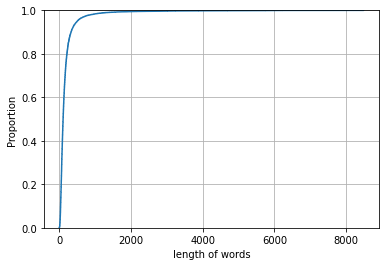

In [ ]:
sns.ecdfplot(x=length)
plt.xlabel('length of words')
plt.grid()

(0.0, 800.0)

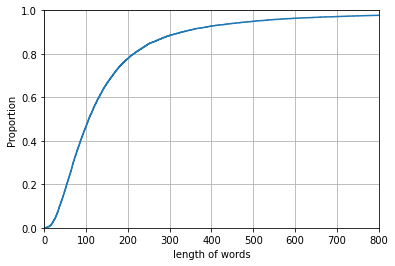

In [ ]:
#Zooming in a little bit of above plot
sns.ecdfplot(x=length)
plt.xlabel('length of words')
plt.grid()
plt.xlim(0,800)

In [ ]:
print(Fore.YELLOW+f"The maximum length of the sentence in our dataset is {int(np.percentile(length,100))}, 95% of points are less than the length {int(np.percentile(length,95))} so i take {int(np.percentile(length,95))} as threshold and strip the documents which has more than the length {int(np.percentile(length,95))} . I am doing this because if we include remaining 5% points then our dataset dimensions will be {int(np.percentile(length,100))}")

The maximum length of the sentence in our dataset is 8486, 95% of points are less than the length 501 so i take 501 as threshold and strip the documents which has more than the length 501 . I am doing this because if we include remaining 5% points then our dataset dimensions will be 8486


In [ ]:
token=Tokenizer()
token.fit_on_texts(x_train)
x_train_token=token.texts_to_sequences(x_train)
x_test_token=token.texts_to_sequences(x_test)

In [ ]:
one=OneHotEncoder()
y_train_final=one.fit_transform(np.array(y_train).reshape(-1,1))
y_test_final=one.transform(np.array(y_test).reshape(-1,1))

In [ ]:
print(f"setting max length of document is {int(np.percentile(length,95))}")
x_train_final=pad_sequences(x_train_token,padding='post',truncating='post',maxlen=int(np.percentile(length,95)))
x_test_final=pad_sequences(x_test_token,padding='post',truncating='post',maxlen=int(np.percentile(length,95)))

setting max length of document is 501


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip 'glove.6B.zip'

In [ ]:
glove = {}
f = open('glove.6B/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    glove[word] = np.asarray(values[1:], dtype='float32')
f.close()

0it [00:00, ?it/s]

In [ ]:
embidding_matrix=[]
count=0
ind=token.word_index
embidding_matrix.append(np.zeros((300)))
for i in ind:
    try:
        embidding_matrix.append(glove[i])
    except Exception:
        embidding_matrix.append(np.zeros((300)))
embidding_matrix=np.array(embidding_matrix)

In [ ]:
#custom micro f1 score 
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def micro_f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(
    log_dir="logs",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
print('storing Logs for tensorboard in following directory : ',os.getcwd())

storing Logs for tensorboard in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    'best_model_L.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)
print('storing best model in following directory : ',os.getcwd())

storing best model in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
#This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
#then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
#difference also and you can monitor it using this metric
from math import sqrt,exp
class overfit_metric(tf.keras.callbacks.Callback):
    """This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
       then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
       difference also and you can monitor it using this metric, This is caluclated with harmonic mean of (1/diff) and validation accuracy , where diff is difference
       of accuracy between train accuracy and validation accuracy """
    def on_epoch_end(self,epoch,log=None):
        val=log['val_accuracy']
        acc=log['accuracy']
        diff=abs(log['accuracy']-val)
        log['overfit_paramater']=2*(1/exp(diff))*val/((1/exp(diff)+val))

In [ ]:
###### hyperparamaters ######
first_layer_filters=16
m=5
n=3
o=1
second_layer_filter=16
i=5
j=3
k=1
third_layer_filter=16
third_layer_kernel_size=5
dropout=0.2
dense=256
activate='relu'
pad='same'
regularizer="l2"

In [ ]:
model_input=Input(shape=(x_train_final.shape[1]))
model=Embedding(embidding_matrix.shape[0],embidding_matrix.shape[1],trainable=False,weights=[embidding_matrix])(model_input)
l1=Conv1D(filters=first_layer_filters,kernel_size=m,activation=activate,padding=pad,kernel_regularizer=regularizer)(model)
l2=Conv1D(filters=first_layer_filters,kernel_size=n,activation=activate,padding=pad,kernel_regularizer=regularizer)(model)
l3=Conv1D(filters=first_layer_filters,kernel_size=o,activation=activate,padding=pad,kernel_regularizer=regularizer)(model)
model=Concatenate()([l1,l2,l3])
model=MaxPool1D()(model)
l1=Conv1D(filters=second_layer_filter,kernel_size=i,activation=activate,padding=pad,kernel_regularizer=regularizer)(model)
l2=Conv1D(filters=second_layer_filter,kernel_size=j,activation=activate,padding=pad,kernel_regularizer=regularizer)(model)
l3=Conv1D(filters=second_layer_filter,kernel_size=k,activation=activate,padding=pad,kernel_regularizer=regularizer)(model)
model=Concatenate()([l1,l2,l3])
model=MaxPool1D()(model)
model=Conv1D(filters=third_layer_filter,kernel_size=third_layer_kernel_size,activation=activate,kernel_regularizer=regularizer)(model)
model=Flatten()(model)
model=Dropout(dropout)(model)
model=Dense(dense,activation=activate,kernel_regularizer=regularizer)(model)
model=Dense(20,activation='softmax')(model)
model=Model(inputs=[model_input],outputs=[model])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',micro_f1])
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 501)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 501, 300)     38809800    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 501, 16)      24016       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 501, 16)      14416       ['embedding[0][0]']              
                                                                                              

In [ ]:
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)

In [ ]:
#from tensorflow.keras.models import load_model
#model=load_model('best_model_L.h5',compile=False)    #To load already trained and saved model
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',micro_f1])

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/ 
%tensorboard --logdir './logs' --host "0.0.0.0" --port 6006

In [ ]:
model.fit(x_train_final,y_train_final.toarray(),validation_split=0.2,
          callbacks=[tensorboard,checkpoint,early_stopping,overfit_metric()]
          ,epochs=4000)

Epoch 1/4000
353/353 [==============================] - ETA: 0s - loss: 3.2875 - accuracy: 0.2376 - micro_f1: 0.0822

2022-08-07 15:53:21.923668: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9314352000 exceeds 10% of free system memory.


353/353 [==============================] - 37s 98ms/step - loss: 3.2875 - accuracy: 0.2376 - micro_f1: 0.0822 - val_loss: 2.1707 - val_accuracy: 0.3724 - val_micro_f1: 0.2165 - overfit_paramater: 0.5222
Epoch 2/4000
353/353 [==============================] - ETA: 0s - loss: 1.9247 - accuracy: 0.4718 - micro_f1: 0.3536

2022-08-07 15:53:56.632921: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9314352000 exceeds 10% of free system memory.


353/353 [==============================] - 35s 98ms/step - loss: 1.9247 - accuracy: 0.4718 - micro_f1: 0.3536 - val_loss: 1.8062 - val_accuracy: 0.5165 - val_micro_f1: 0.3524 - overfit_paramater: 0.6707
Epoch 3/4000
353/353 [==============================] - ETA: 0s - loss: 1.6746 - accuracy: 0.5728 - micro_f1: 0.4893

2022-08-07 15:54:31.044370: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9314352000 exceeds 10% of free system memory.


353/353 [==============================] - 34s 98ms/step - loss: 1.6746 - accuracy: 0.5728 - micro_f1: 0.4893 - val_loss: 1.5856 - val_accuracy: 0.6088 - val_micro_f1: 0.5526 - overfit_paramater: 0.7465
Epoch 4/4000
353/353 [==============================] - ETA: 0s - loss: 1.5507 - accuracy: 0.6295 - micro_f1: 0.5784

2022-08-07 15:55:05.747819: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9314352000 exceeds 10% of free system memory.


353/353 [==============================] - 35s 98ms/step - loss: 1.5507 - accuracy: 0.6295 - micro_f1: 0.5784 - val_loss: 1.5685 - val_accuracy: 0.6234 - val_micro_f1: 0.5781 - overfit_paramater: 0.7662
Epoch 5/4000
353/353 [==============================] - ETA: 0s - loss: 1.4831 - accuracy: 0.6610 - micro_f1: 0.6110

2022-08-07 15:55:40.083976: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9314352000 exceeds 10% of free system memory.


353/353 [==============================] - 34s 97ms/step - loss: 1.4831 - accuracy: 0.6610 - micro_f1: 0.6110 - val_loss: 1.4719 - val_accuracy: 0.6676 - val_micro_f1: 0.6313 - overfit_paramater: 0.7986
Epoch 6/4000
353/353 [==============================] - 34s 96ms/step - loss: 1.4273 - accuracy: 0.6800 - micro_f1: 0.6405 - val_loss: 1.5003 - val_accuracy: 0.6552 - val_micro_f1: 0.6175 - overfit_paramater: 0.7839
Epoch 7/4000
353/353 [==============================] - 35s 100ms/step - loss: 1.3883 - accuracy: 0.7014 - micro_f1: 0.6611 - val_loss: 1.4205 - val_accuracy: 0.6924 - val_micro_f1: 0.6604 - overfit_paramater: 0.8152
Epoch 8/4000
353/353 [==============================] - 34s 97ms/step - loss: 1.3443 - accuracy: 0.7203 - micro_f1: 0.6900 - val_loss: 1.4074 - val_accuracy: 0.7058 - val_micro_f1: 0.6895 - overfit_paramater: 0.8226
Epoch 9/4000
353/353 [==============================] - 34s 96ms/step - loss: 1.2990 - accuracy: 0.7373 - micro_f1: 0.7132 - val_loss: 1.4187 - val_

In [ ]:
model_1=model

### Testing model performance on Test data

In [ ]:
evaluate=model.predict(x_test_final)

148/148 [==============================] - 3s 21ms/step


In [ ]:
print(classification_report(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       200
           1       0.60      0.65      0.63       243
           2       0.67      0.71      0.69       246
           3       0.49      0.72      0.58       246
           4       0.80      0.45      0.58       240
           5       0.54      0.68      0.60       245
           6       0.68      0.68      0.68       243
           7       0.73      0.90      0.80       248
           8       0.96      0.71      0.82       249
           9       0.96      0.88      0.92       248
          10       0.93      0.92      0.93       250
          11       0.88      0.86      0.87       248
          12       0.63      0.66      0.65       245
          13       0.93      0.83      0.88       247
          14       0.92      0.81      0.86       247
          15       0.67      0.87      0.76       249
          16       0.84      0.65      0.73       227
          17       0.77    

In [ ]:
print(f'Micro F1 score on Test data is : {f1_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1),average="micro")}')

Micro F1 score on Test data is : 0.7365625663904822


In [ ]:
print(f"Accuracy on Test data is : {accuracy_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1))}")

Accuracy on Test data is : 0.7365625663904822


Text(159.0, 0.5, 'Original Class')

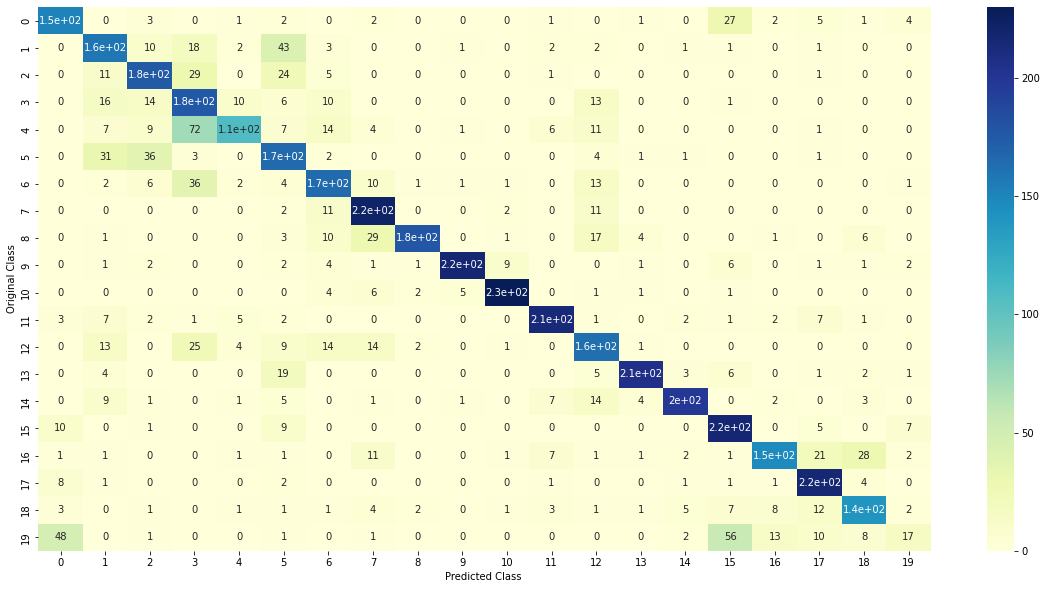

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)),annot=True,cmap="YlGnBu")
plt.xlabel('Predicted Class ')
plt.ylabel('Original Class')

### Hyperparamater Tuning 

In [ ]:
#splitting training and validation data , taking 20% as validation data
train=x_train_token[:int(0.8*len(x_train_token))] 
cv=x_train_token[int(0.8*len(x_train_token)):]
y_train=y_train_final[:int(0.8*len(x_train_token))]
y_cv_train=y_train_final[int(0.8*len(x_train_token)):]

In [ ]:
def create_model(hp):
    
    global train
    global cv
    global tr
    global te
    aa=hp.Int('Max length of document in percentile',min_value=50,max_value=98,step=10)   # Treating max length of the document as a hyper paramater
    tr=pad_sequences(train,padding='post',maxlen=int(np.percentile(length,aa))) 
    te=pad_sequences(cv,padding='post',maxlen=int(np.percentile(length,aa)))
    
    ####################################### hyperparamaters ##############################################################
    
    first_layer_filters=hp.Int("no of filters",min_value=1,max_value=20,step=5) #first convolution set filter 
    m=hp.Choice("kernel",values=[7,5])  #first convolution set kernel size
    n=3  #first convolution set kernel size
    o=1  #first convolution set kernel size
    second_layer_filter=hp.Int("no of filters_1",min_value=1,max_value=20,step=5) #second convolution set filter 
    i=1  #second convolution set kernel size
    j=3  #second convolution set kernel size
    k=hp.Choice("kernel1",values=[7,5])  #second convolution set kernel size
    third_layer_filter=hp.Int("no of filters_2",min_value=1,max_value=30,step=5) #third convolution set filter 
    third_layer_kernel_size=hp.Choice("kernel3",values=[7,5])  #third convolution set kernel size
    dropout=hp.Float("Drop out",min_value=0,max_value=0.8,step=0.2)
    dense=hp.Choice("Dense",values=[256,512,1024,2048])
    activate=hp.Choice("activation function",values=['relu','elu','selu','tanh'])
    pad='same'
    regularizer=hp.Choice('Regularization',values=['l1','l2'])
    
    ############################################ Model Building ###########################################################
    
    model_input=Input(shape=(hp.Fixed('shape',tr.shape[1]))) 
    model=Embedding(embidding_matrix.shape[0],embidding_matrix.shape[1],trainable=False,weights=[embidding_matrix])(model_input)
    model=BatchNormalization()(model)
    l1=Conv1D(filters=first_layer_filters,kernel_size=m,padding=pad,kernel_regularizer=regularizer)(model)
    l1=BatchNormalization()(l1)
    l1=Activation(activate)(l1)
    l2=Conv1D(filters=first_layer_filters,kernel_size=n,padding=pad,kernel_regularizer=regularizer)(model)
    l2=BatchNormalization()(l2)
    l2=Activation(activate)(l2)
    l3=Conv1D(filters=first_layer_filters,kernel_size=o,padding=pad,kernel_regularizer=regularizer)(model)
    l3=BatchNormalization()(l3)    
    l3=Activation(activate)(l3)
    model=Concatenate()([l1,l2,l3])
    model=MaxPool1D()(model)
    l1=Conv1D(filters=second_layer_filter,kernel_size=i,padding=pad,kernel_regularizer=regularizer)(model)
    l1=BatchNormalization()(l1)  
    l1=Activation(activate)(l1)
    l2=Conv1D(filters=second_layer_filter,kernel_size=j,padding=pad,kernel_regularizer=regularizer)(model)
    l2=BatchNormalization()(l2)    
    l2=Activation(activate)(l2)
    l3=Conv1D(filters=second_layer_filter,kernel_size=k,padding=pad,kernel_regularizer=regularizer)(model)
    l3=BatchNormalization()(l3)        
    l3=Activation(activate)(l3)
    model=Concatenate()([l1,l2,l3])
    model=MaxPool1D()(model)
    model=Conv1D(filters=third_layer_filter,kernel_size=third_layer_kernel_size,activation=activate,kernel_regularizer=regularizer)(model)
    model=Flatten()(model)
    model=BatchNormalization()(model)
    model=Dropout(dropout)(model)
    model=Dense(dense,activation=activate,kernel_regularizer=regularizer)(model)
    model=BatchNormalization()(model)
    model=Dense(20,activation='softmax')(model)
    model=Model(inputs=[model_input],outputs=[model])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',micro_f1])
    
    return model

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False, # if True, keras tuner taking up full hard disk , anyway i will train again with best hyper paramaters again
)

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(
    log_dir="logs100",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
print('storing Logs for tensorboard in following directory : ',os.getcwd())

storing Logs for tensorboard in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
#This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
#then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
#difference also and you can monitor it using this metric
from math import sqrt,exp
class overfit_metric(tf.keras.callbacks.Callback):
    """This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
       then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
       difference also and you can monitor it using this metric, This is caluclated with harmonic mean of (1/diff) and validation accuracy , where diff is difference
       of accuracy between train accuracy and validation accuracy """
    def on_epoch_end(self,epoch,log=None):
        val=log['val_accuracy']
        acc=log['accuracy']
        diff=abs(log['accuracy']-val)
        log['overfit_paramater']=2*(1/exp(diff))*val/((1/exp(diff)+val))

In [ ]:
#even single epoch taking days for some hyperparparamaters , so limitting any model training to 40 min for every half in hyper band
import time
class mycallback(tf.keras.callbacks.Callback):   # if training time takes more than 40 min , then training will stop
    def on_train_begin(self, logs=None):
        self.started_time=time.time()
    def on_train_batch_end(self, batch, logs=None):
        if (time.time()-self.started_time)>60*40 : #40 minutes
            self.model.stop_training = True

In [ ]:
!rm -r first_model
os.mkdir('first_model')

In [ ]:
# tuner.search() is saving model checkpoints in hard disk for all models which is building up to very large space in Hard disk so i delete them
# manually for every 10 minutes in background
@background.task
def remove_checkpoints():
    while True:     
        dirr='first_model'
        files=os.listdir(dirr)
        for i in files:
            try:
                for j in (os.listdir(dirr+'/'+i)):
                    if 'checkpoint' in j:
                        os.remove(dirr+'/'+i+'/'+j)
            except Exception as error:
                pass
        sleep(10*60)

remove_checkpoints()

<Future at 0xffff1492ccd0 state=running>

In [ ]:
tun=keras_tuner.BayesianOptimization(create_model,'val_accuracy',max_trials=40,num_initial_points=10,project_name='first_model',overwrite=True)

In [ ]:
%load_ext tensorboard
!rm -rf ./logs100/ 
%tensorboard --logdir './logs100' --host "0.0.0.0" --port 6017

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
tun.search(tr,y_train.toarray(),callbacks=[early_stopping,tensorboard,overfit_metric(),mycallback()],validation_data=(te,y_cv_train.toarray()),epochs=30)

Trial 40 Complete [00h 04m 03s]
val_accuracy: 0.6736283302307129

Best val_accuracy So Far: 0.7015929222106934
Total elapsed time: 02h 36m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tun.results_summary()

Results summary
Results in ./first_model
Showing 10 best trials
Trial summary
Hyperparameters:
Max length of document in percentile: 50
no of filters: 16
kernel: 7
no of filters_1: 16
kernel1: 5
no of filters_2: 26
kernel3: 5
Drop out: 0.8
Dense: 256
activation function: relu
Regularization: l2
shape: 107
Score: 0.7015929222106934
Trial summary
Hyperparameters:
Max length of document in percentile: 50
no of filters: 16
kernel: 7
no of filters_1: 16
kernel1: 5
no of filters_2: 26
kernel3: 5
Drop out: 0.8
Dense: 256
activation function: relu
Regularization: l2
shape: 107
Score: 0.695929229259491
Trial summary
Hyperparameters:
Max length of document in percentile: 50
no of filters: 16
kernel: 7
no of filters_1: 16
kernel1: 5
no of filters_2: 26
kernel3: 7
Drop out: 0.8
Dense: 256
activation function: relu
Regularization: l2
shape: 107
Score: 0.6821238994598389
Trial summary
Hyperparameters:
Max length of document in percentile: 50
no of filters: 16
kernel: 7
no of filters_1: 16
kernel1: 5

### Traning on best hyparamaters given by bayesian optimization 

In [ ]:
best_hps = tun.get_best_hyperparameters(1)[0]
model=create_model(best_hps)

In [ ]:
x_train_final=pad_sequences(x_train_token,padding='post',truncating='post',maxlen=model.input_shape[1]) #changing the document length 
x_test_final=pad_sequences(x_test_token,padding='post',truncating='post',maxlen=model.input_shape[1]) #changing the document length 

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(
    log_dir="logs2",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
print('storing Logs for tensorboard in following directory : ',os.getcwd())

storing Logs for tensorboard in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    'best_model_L.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)
print('storing best model in following directory : ',os.getcwd())

storing best model in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
#This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
#then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
#difference also and you can monitor it using this metric
from math import sqrt,exp
class overfit_metric(tf.keras.callbacks.Callback):
    """This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
       then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
       difference also and you can monitor it using this metric, This is caluclated with harmonic mean of (1/diff) and validation accuracy , where diff is difference
       of accuracy between train accuracy and validation accuracy """
    def on_epoch_end(self,epoch,log=None):
        val=log['val_accuracy']
        acc=log['accuracy']
        diff=abs(log['accuracy']-val)
        log['overfit_paramater']=2*(1/exp(diff))*val/((1/exp(diff)+val))

In [ ]:
%load_ext tensorboard
!rm -rf ./logs2/ 
%tensorboard --logdir './logs2' --host "0.0.0.0" --port 6008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model.fit(x_train_final,y_train_final.toarray(),validation_split=0.2,
          callbacks=[tensorboard,checkpoint,early_stopping,overfit_metric()]
          ,epochs=4000)

Epoch 1/4000
353/353 [==============================] - 21s 50ms/step - loss: 6.9141 - accuracy: 0.1825 - micro_f1: 0.1022 - val_loss: 4.9145 - val_accuracy: 0.3664 - val_micro_f1: 0.2000 - overfit_paramater: 0.5087
Epoch 2/4000
353/353 [==============================] - 17s 49ms/step - loss: 4.0713 - accuracy: 0.4191 - micro_f1: 0.3567 - val_loss: 3.1261 - val_accuracy: 0.5384 - val_micro_f1: 0.4738 - overfit_paramater: 0.6702
Epoch 3/4000
353/353 [==============================] - 17s 48ms/step - loss: 2.8277 - accuracy: 0.5366 - micro_f1: 0.4950 - val_loss: 2.2951 - val_accuracy: 0.6290 - val_micro_f1: 0.5626 - overfit_paramater: 0.7444
Epoch 4/4000
353/353 [==============================] - 17s 48ms/step - loss: 2.1872 - accuracy: 0.6018 - micro_f1: 0.5725 - val_loss: 1.9645 - val_accuracy: 0.6198 - val_micro_f1: 0.5921 - overfit_paramater: 0.7600
Epoch 5/4000
353/353 [==============================] - 17s 49ms/step - loss: 1.9087 - accuracy: 0.6290 - micro_f1: 0.6117 - val_loss: 1

In [ ]:
model_2=model

### Testing model performance on Test data

In [ ]:
evaluate=model.predict(x_test_final)

148/148 [==============================] - 2s 9ms/step


In [ ]:
print(classification_report(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.61      0.72       200
           1       0.62      0.71      0.66       243
           2       0.70      0.59      0.64       246
           3       0.53      0.66      0.59       246
           4       0.82      0.62      0.71       240
           5       0.64      0.65      0.65       245
           6       0.80      0.66      0.73       243
           7       0.83      0.84      0.83       248
           8       0.99      0.67      0.80       249
           9       0.94      0.88      0.91       248
          10       0.94      0.94      0.94       250
          11       0.80      0.93      0.86       248
          12       0.63      0.79      0.70       245
          13       0.83      0.91      0.87       247
          14       0.90      0.85      0.87       247
          15       0.73      0.84      0.78       249
          16       0.67      0.76      0.71       227
          17       0.80    

In [ ]:
print(f'Micro F1 score on Test data is : {f1_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1),average="micro")}')

Micro F1 score on Test data is : 0.7554705757382622


In [ ]:
print(f"Accuracy on Test data is : {accuracy_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1))}")

Accuracy on Test data is : 0.7554705757382622


Text(159.0, 0.5, 'Original Class')

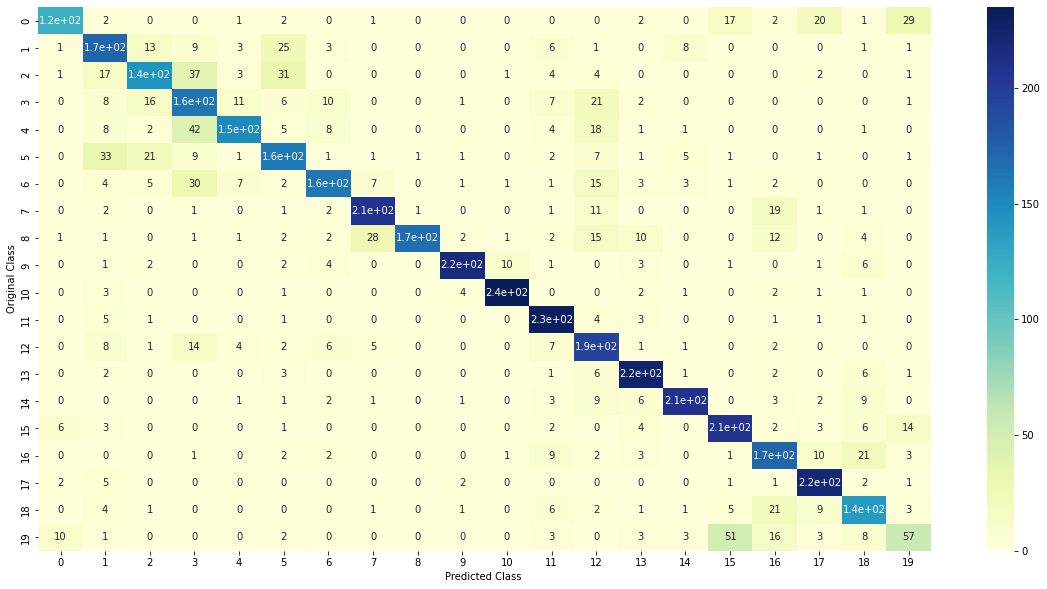

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)),annot=True,cmap="YlGnBu")
plt.xlabel('Predicted Class ')
plt.ylabel('Original Class')

## Instead using word embidding , trying character level embidding and checking if it increases model performance

### Model-2 : Using 1D convolutions with character embedding

<pre>
<pre><img src="https://i.ytimg.com/vi/CNY8VjJt-iQ/maxresdefault.jpg" width="70%">
Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Use the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>
</pre>

In [ ]:
#!wget https://raw.githubusercontent.com/minimaxir/char-embeddings/master/glove.840B.300d-char.txt

In [ ]:
token=Tokenizer(char_level=True)
token.fit_on_texts(x_train)
x_train_token=token.texts_to_sequences(x_train)
x_test_token=token.texts_to_sequences(x_test)

In [ ]:
length=[]
for i in x_train_token:
    length.append(len(i))

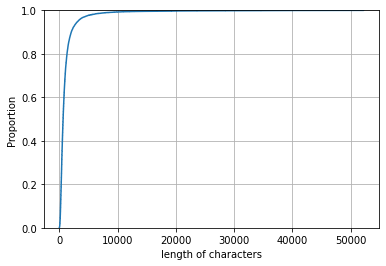

In [ ]:
sns.ecdfplot(x=length)
plt.xlabel('length of characters')
plt.grid()

(0.0, 3000.0)

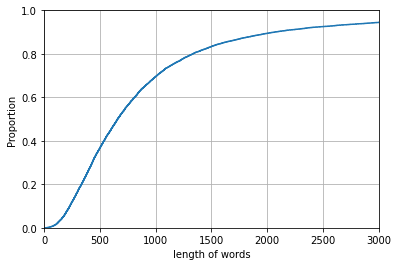

In [ ]:
#Zooming in a little bit of above plot
sns.ecdfplot(x=length)
plt.xlabel('length of words')
plt.grid()
plt.xlim(0,3000)

In [ ]:
from colorama import Fore, Back, Style
print(Fore.YELLOW+f"The maximum length of the sentence in our dataset is {int(np.percentile(length,100))}, 95% of points are less than the length {int(np.percentile(length,95))} so i take {int(np.percentile(length,95))} as threshold and strip the documents which has more than the length {int(np.percentile(length,95))} . I am doing this because if we include remaining 5% points then our dataset dimensions will be {int(np.percentile(length,100))}")

The maximum length of the sentence in our dataset is 52213, 95% of points are less than the length 3212 so i take 3212 as threshold and strip the documents which has more than the length 3212 . I am doing this because if we include remaining 5% points then our dataset dimensions will be 52213


In [ ]:
print(f"setting max length of document is {int(np.percentile(length,95))}")
x_train_final=pad_sequences(x_train_token,padding='post',truncating='post',maxlen=int(np.percentile(length,95)))
x_test_final=pad_sequences(x_test_token,padding='post',truncating='post',maxlen=int(np.percentile(length,95)))

setting max length of document is 3212


In [ ]:
glove = {}
f = open('glove.840B.300d-char.txt.1')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    glove[word] = np.asarray(values[1:], dtype='float32')
f.close()

0it [00:00, ?it/s]

In [ ]:
embidding_matrix=[]
count=0
ind=token.word_index
embidding_matrix.append(np.zeros((300)))
for i in ind:
    try:
        embidding_matrix.append(glove[i])
    except Exception:
        embidding_matrix.append(np.zeros((300)))
embidding_matrix=np.array(embidding_matrix)

In [ ]:
first_kernel=3
second_kernel=3
third_kernel=3
fourth_kernel=3
n=16 #first convolution filters
m=16 #second convolution filters
k=16 #third convolution filters
t=16 #fourth convolution filters
act='relu'
drop=0.2
dense=256
batchnormal=False

In [ ]:
model_input=Input(shape=(x_train_final.shape[1]))
model=Embedding(embidding_matrix.shape[0],embidding_matrix.shape[1],trainable=False,weights=[embidding_matrix])(model_input)

model=Conv1D(filters=n,kernel_size=first_kernel)(model)
if batchnormal:
    model=BatchNormalization()(model)
model=Activation(act)(model)

model=Conv1D(filters=m,kernel_size=second_kernel)(model)
if batchnormal:
    model=BatchNormalization()(model)
model=Activation(act)(model)

model=MaxPool1D()(model)

model=Conv1D(filters=k,kernel_size=third_kernel)(model)
if batchnormal:
    model=BatchNormalization()(model)
model=Activation(act)(model)

model=Conv1D(filters=t,kernel_size=fourth_kernel)(model)
if batchnormal:
    model=BatchNormalization()(model)
model=Activation(act)(model)

model=MaxPool1D()(model)

model=Flatten()(model)
if batchnormal:
    model=BatchNormalization()(model)
model=Dropout(drop)(model)

model=Dense(dense)(model)

model=Dense(20,activation='softmax')(model)

model=Model(inputs=[model_input],outputs=[model])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',micro_f1])

model.summary()
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3212)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 3212, 300)         14400     
                                                                 
 conv1d_14 (Conv1D)          (None, 3210, 16)          14416     
                                                                 
 activation_12 (Activation)  (None, 3210, 16)          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 3208, 16)          784       
                                                                 
 activation_13 (Activation)  (None, 3208, 16)          0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1604, 16)         0   

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(
    log_dir="logs5",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
print('storing Logs for tensorboard in following directory : ',os.getcwd())

storing Logs for tensorboard in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
#This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
#then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
#difference also and you can monitor it using this metric
from math import sqrt,exp
class overfit_metric(tf.keras.callbacks.Callback):
    """This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
       then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
       difference also and you can monitor it using this metric, This is caluclated with harmonic mean of (1/diff) and validation accuracy , where diff is difference
       of accuracy between train accuracy and validation accuracy """
    def on_epoch_end(self,epoch,log=None):
        val=log['val_accuracy']
        acc=log['accuracy']
        diff=abs(log['accuracy']-val)
        log['overfit_paramater']=2*(1/exp(diff))*val/((1/exp(diff)+val))

In [ ]:
%load_ext tensorboard
!rm -rf ./logs5/ 
%tensorboard --logdir './logs5' --host "0.0.0.0" --port 6009

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model.fit(x_train_final,y_train_final.toarray(),validation_split=0.2,
          callbacks=[tensorboard,checkpoint,early_stopping,mycallback(),overfit_metric()]
          ,epochs=4000)

Epoch 1/4000
353/353 [==============================] - 84s 236ms/step - loss: 2.9403 - accuracy: 0.0780 - micro_f1: 6.7245e-04 - val_loss: 2.9372 - val_accuracy: 0.0800 - val_micro_f1: 0.0000e+00 - overfit_paramater: 0.1481
Epoch 2/4000
353/353 [==============================] - 83s 236ms/step - loss: 2.8967 - accuracy: 0.0963 - micro_f1: 0.0024 - val_loss: 2.8876 - val_accuracy: 0.0931 - val_micro_f1: 6.8097e-04 - overfit_paramater: 0.1703
Epoch 3/4000
353/353 [==============================] - 83s 235ms/step - loss: 2.8429 - accuracy: 0.1154 - micro_f1: 0.0075 - val_loss: 2.9117 - val_accuracy: 0.1012 - val_micro_f1: 0.0082 - overfit_paramater: 0.1836
Epoch 4/4000
353/353 [==============================] - 86s 244ms/step - loss: 2.6594 - accuracy: 0.1743 - micro_f1: 0.0377 - val_loss: 2.9883 - val_accuracy: 0.0984 - val_micro_f1: 0.0106 - overfit_paramater: 0.1779
Epoch 5/4000
353/353 [==============================] - 89s 253ms/step - loss: 2.4318 - accuracy: 0.2327 - micro_f1: 0.1

In [ ]:
model_3=model

### Testing model performance on Test data

In [ ]:
evaluate=model.predict(x_test_final)

148/148 [==============================] - 11s 71ms/step


In [ ]:
print(classification_report(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)))

              precision    recall  f1-score   support

           0       0.28      0.04      0.06       200
           1       0.08      0.13      0.10       243
           2       0.05      0.03      0.04       246
           3       0.09      0.06      0.07       246
           4       0.11      0.10      0.11       240
           5       0.11      0.07      0.08       245
           6       0.15      0.28      0.20       243
           7       0.04      0.01      0.01       248
           8       0.04      0.03      0.03       249
           9       0.05      0.11      0.07       248
          10       0.08      0.17      0.11       250
          11       0.06      0.12      0.08       248
          12       0.09      0.02      0.04       245
          13       0.08      0.09      0.08       247
          14       0.12      0.09      0.10       247
          15       0.13      0.21      0.16       249
          16       0.10      0.03      0.05       227
          17       0.15    

In [ ]:
print(f'Micro F1 score on Test data is : {f1_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1),average="micro")}')

Micro F1 score on Test data is : 0.09411514765243255


In [ ]:
print(f"Accuracy on Test data is : {accuracy_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1))}")

Accuracy on Test data is : 0.09411514765243255


Text(159.0, 0.5, 'Original Class')

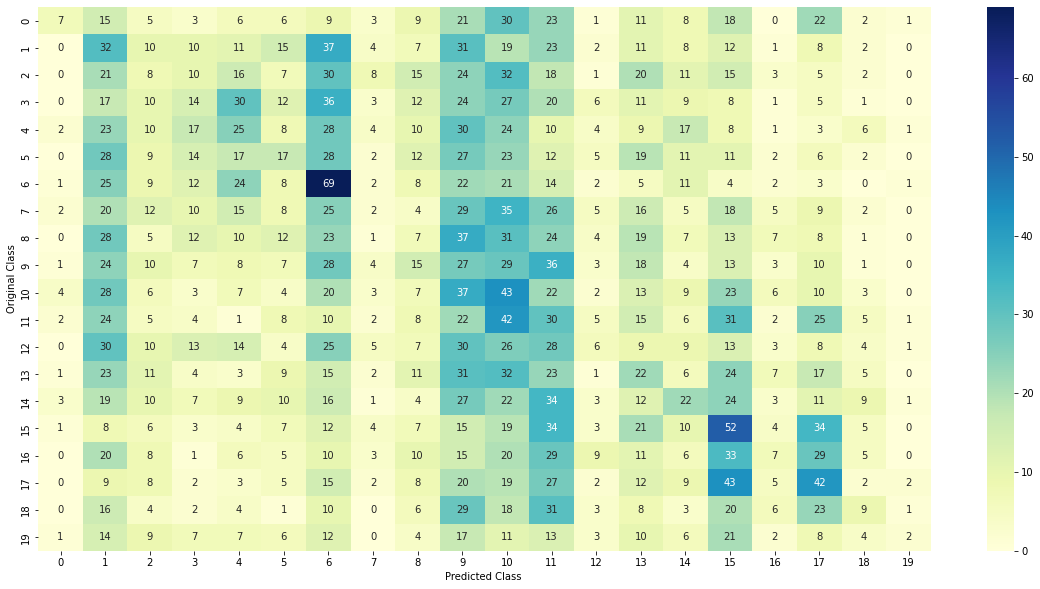

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)),annot=True,cmap="YlGnBu")
plt.xlabel('Predicted Class ')
plt.ylabel('Original Class')

### Hyper paramater Tuning

In [ ]:
#splitting training and cross validation data , taking 20% as cross validation data
train=x_train_token[:int(0.8*len(x_train_token))] 
cv=x_train_token[int(0.8*len(x_train_token)):]
y_train=y_train_final[:int(0.8*len(x_train_token))]
y_cv_train=y_train_final[int(0.8*len(x_train_token)):]

In [ ]:
try: 
    del tr
    del te
    del aa
    del train
    del cv
except:
    pass

In [ ]:
def create_model(hp):
    global train
    global cv
    global tr
    global te
    aa=hp.Int('Max length of document in percentile',min_value=50,max_value=95,step=8)   # Treating max length of the document as a hyper paramater
    tr=pad_sequences(train,padding='post',maxlen=int(np.percentile(length,aa))) 
    te=pad_sequences(cv,padding='post',maxlen=int(np.percentile(length,aa)))
    ################################ hyperparamaters ##############################################################
    
    first_kernel=hp.Choice("kernel",values=[1,3,7]) 
    second_kernel=hp.Choice("kernel_1",values=[1,3,7]) 
    third_kernel=hp.Choice("kernel_2",values=[1,3,7]) 
    fourth_kernel=hp.Choice("kernel_3",values=[1,3,7]) 
    n= hp.Int("filters",min_value=1,max_value=50,step=5)#first convolution filters
    m=hp.Int("filters_1",min_value=1,max_value=50,step=5) #second convolution filters
    k=hp.Int("filters_2",min_value=1,max_value=50,step=5) #third convolution filters
    t=hp.Int("filters_3",min_value=1,max_value=50,step=5)#fourth convolution filters
    regularizer=hp.Choice('Regularization',values=['l1','l2'])
    drop=hp.Float("Drop out",min_value=0,max_value=0.8,step=0.2)
    dense=hp.Choice("Dense",values=[256,512,1024,2048])
    act=hp.Choice("activation function",values=['relu','elu','selu','tanh','sigmoid'])
    pad='same'
    batchnormal=hp.Boolean("batchnormalization")
    ######################################## Model Building ##########################################################
    model_input=Input(shape=(hp.Fixed('shape',tr.shape[1]))) 
    model=Embedding(embidding_matrix.shape[0],embidding_matrix.shape[1],trainable=False,weights=[embidding_matrix])(model_input)

    model=Conv1D(filters=n,kernel_size=first_kernel,kernel_regularizer=regularizer)(model)
    if batchnormal:
        model=BatchNormalization()(model)
    model=Activation(act)(model)

    model=Conv1D(filters=m,kernel_size=second_kernel,kernel_regularizer=regularizer)(model)
    if batchnormal:
        model=BatchNormalization()(model)
    model=Activation(act)(model)

    model=MaxPool1D()(model)

    model=Conv1D(filters=k,kernel_size=third_kernel,kernel_regularizer=regularizer)(model)
    if batchnormal:
        model=BatchNormalization()(model)
    model=Activation(act)(model)

    model=Conv1D(filters=t,kernel_size=fourth_kernel,kernel_regularizer=regularizer)(model)
    if batchnormal:
        model=BatchNormalization()(model)
    model=Activation(act)(model)

    model=MaxPool1D()(model)

    model=Flatten()(model)
    if batchnormal:
        model=BatchNormalization()(model)
    model=Dropout(drop)(model)

    model=Dense(dense,kernel_regularizer=regularizer)(model)

    model=Dense(20,activation='softmax')(model)

    model=Model(inputs=[model_input],outputs=[model])

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',micro_f1])  
    return model

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False, #  anyway i will train again with best hyper paramaters again
)

In [ ]:
#This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
#then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
#difference also and you can monitor it using this metric
from math import sqrt,exp
class overfit_metric(tf.keras.callbacks.Callback):
    """This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
       then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
       difference also and you can monitor it using this metric, This is caluclated with harmonic mean of (1/diff) and validation accuracy , where diff is difference
       of accuracy between train accuracy and validation accuracy """
    def on_epoch_end(self,epoch,log=None):
        val=log['val_accuracy']
        acc=log['accuracy']
        diff=abs(log['accuracy']-val)
        log['overfit_paramater']=2*(1/exp(diff))*val/((1/exp(diff)+val))

In [ ]:
#even single epoch taking days for some hyperparparamaters , so limitting any model training to 20 min for every half in hyper band
import time
class mycallback(tf.keras.callbacks.Callback):   # if training time takes more than 40 min , then training will stop
    def on_train_begin(self, logs=None):
        self.started_time=time.time()
    def on_train_batch_end(self, batch, logs=None):
        if (time.time()-self.started_time)>60*40 : #40 minutes
            self.model.stop_training = True

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(
    log_dir="logs7",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
print('storing Logs for tensorboard in following directory : ',os.getcwd())

storing Logs for tensorboard in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
!rm -r second_model
os.mkdir('second_model')

rm: cannot remove 'second_model': No such file or directory


In [ ]:
# tuner.search() is saving model checkpoints in hard disk for all models which is building up to very large space in Hard disk so i delete them
# manually for every 10 minutes in background
@background.task
def remove_checkpoints():
    while True:     
        dirr='second_model'
        files=os.listdir(dirr)
        for i in files:
            try:
                for j in (os.listdir(dirr+'/'+i)):
                    if 'checkpoint' in j:
                        os.remove(dirr+'/'+i+'/'+j)
            except Exception as error:
                pass
        sleep(10*60)

remove_checkpoints()

<Future at 0xffff41452c20 state=running>

In [ ]:
tun=keras_tuner.BayesianOptimization(create_model,'val_accuracy',max_trials=40,num_initial_points=10,project_name='second_model',overwrite=True)

In [ ]:
%load_ext tensorboard
!rm -rf ./logs7/ 
%tensorboard --logdir './logs7' --host "0.0.0.0" --port 6004

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
tun.search(tr,y_train.toarray(),callbacks=[early_stopping,tensorboard,mycallback(),overfit_metric()],
           validation_data=(te,y_cv_train.toarray()),epochs=40)

Trial 40 Complete [00h 02m 55s]
val_accuracy: 0.08212389051914215

Best val_accuracy So Far: 0.11398229748010635
Total elapsed time: 01h 51m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tun.results_summary()

Results summary
Results in ./second_model
Showing 10 best trials
Trial summary
Hyperparameters:
Max length of document in percentile: 90
kernel: 1
kernel_1: 1
kernel_2: 7
kernel_3: 1
filters: 1
filters_1: 46
filters_2: 46
filters_3: 31
Regularization: l2
Drop out: 0.6000000000000001
Dense: 256
activation function: relu
batchnormalization: True
shape: 659
Score: 0.11398229748010635
Trial summary
Hyperparameters:
Max length of document in percentile: 90
kernel: 1
kernel_1: 1
kernel_2: 7
kernel_3: 1
filters: 1
filters_1: 46
filters_2: 46
filters_3: 31
Regularization: l2
Drop out: 0.4
Dense: 1024
activation function: relu
batchnormalization: True
shape: 659
Score: 0.10796460509300232
Trial summary
Hyperparameters:
Max length of document in percentile: 90
kernel: 1
kernel_1: 1
kernel_2: 7
kernel_3: 1
filters: 1
filters_1: 46
filters_2: 46
filters_3: 46
Regularization: l2
Drop out: 0.6000000000000001
Dense: 256
activation function: relu
batchnormalization: True
shape: 659
Score: 0.1019469052

### Traning on best hyparamaters given by bayesian optimization 

In [ ]:
best_hps = tun.get_best_hyperparameters(1)[0]
model=create_model(best_hps)

In [ ]:
x_train_final=pad_sequences(x_train_token,padding='post',truncating='post',maxlen=model.input_shape[1]) #changing the document length 
x_test_final=pad_sequences(x_test_token,padding='post',truncating='post',maxlen=model.input_shape[1]) #changing the document length 

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(
    log_dir="logs111",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
print('storing Logs for tensorboard in following directory : ',os.getcwd())

storing Logs for tensorboard in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    'best_model_L.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)
print('storing best model in following directory : ',os.getcwd())

storing best model in following directory :  /home/ubuntu/aaic/CNN_with_textdata


In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
#This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
#then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
#difference also and you can monitor it using this metric
from math import sqrt,exp
class overfit_metric(tf.keras.callbacks.Callback):
    """This callback checks if the train accuracy and validation accuracy differs more , if we have 0.95 train accuracy and 0.7 validation accuracy 
       then early stopping stores model with validation 0.7 , it won't see the difference b/w validation accuracy and training accuracy, so this metric sees 
       difference also and you can monitor it using this metric, This is caluclated with harmonic mean of (1/diff) and validation accuracy , where diff is difference
       of accuracy between train accuracy and validation accuracy """
    def on_epoch_end(self,epoch,log=None):
        val=log['val_accuracy']
        acc=log['accuracy']
        diff=abs(log['accuracy']-val)
        log['overfit_paramater']=2*(1/exp(diff))*val/((1/exp(diff)+val))

In [ ]:
%load_ext tensorboard
!rm -rf ./logs111/ 
%tensorboard --logdir './logs111' --host "0.0.0.0" --port 6001

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model.fit(x_train_final,y_train_final.toarray(),validation_split=0.2,
          callbacks=[tensorboard,checkpoint,early_stopping,overfit_metric()]
          ,epochs=4000)

Epoch 1/4000
353/353 [==============================] - 21s 58ms/step - loss: 8.3041 - accuracy: 0.0876 - micro_f1: 0.0364 - val_loss: 7.2454 - val_accuracy: 0.0687 - val_micro_f1: 0.0000e+00 - overfit_paramater: 0.1284
Epoch 2/4000
353/353 [==============================] - 19s 54ms/step - loss: 4.9351 - accuracy: 0.1252 - micro_f1: 5.1507e-04 - val_loss: 4.3692 - val_accuracy: 0.0938 - val_micro_f1: 0.0000e+00 - overfit_paramater: 0.1711
Epoch 3/4000
353/353 [==============================] - 20s 55ms/step - loss: 3.8831 - accuracy: 0.1411 - micro_f1: 3.4338e-04 - val_loss: 3.7683 - val_accuracy: 0.0959 - val_micro_f1: 0.0000e+00 - overfit_paramater: 0.1744
Epoch 4/4000
353/353 [==============================] - 19s 54ms/step - loss: 3.5505 - accuracy: 0.1338 - micro_f1: 1.7169e-04 - val_loss: 3.5327 - val_accuracy: 0.1044 - val_micro_f1: 0.0000e+00 - overfit_paramater: 0.1886
Epoch 5/4000
353/353 [==============================] - 19s 54ms/step - loss: 3.4224 - accuracy: 0.1301 - mi

In [ ]:
model_4=model

### Testing model performance on Test data

In [ ]:
evaluate=model.predict(x_test_final)

148/148 [==============================] - 3s 16ms/step


In [ ]:
print(classification_report(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)))

              precision    recall  f1-score   support

           0       0.14      0.07      0.09       200
           1       0.11      0.02      0.03       243
           2       0.07      0.05      0.06       246
           3       0.10      0.03      0.05       246
           4       0.12      0.01      0.02       240
           5       0.08      0.09      0.09       245
           6       0.14      0.47      0.21       243
           7       0.11      0.03      0.05       248
           8       0.14      0.08      0.10       249
           9       0.10      0.06      0.08       248
          10       0.11      0.18      0.14       250
          11       0.11      0.11      0.11       248
          12       0.02      0.00      0.01       245
          13       0.07      0.02      0.03       247
          14       0.06      0.06      0.06       247
          15       0.09      0.41      0.15       249
          16       0.09      0.13      0.11       227
          17       0.14    

In [ ]:
print(f'Micro F1 score on Test data is : {f1_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1),average="micro")}')

Micro F1 score on Test data is : 0.10346292755470576


In [ ]:
print(f"Accuracy on Test data is : {accuracy_score(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1))}")

Accuracy on Test data is : 0.10346292755470576


Text(159.0, 0.5, 'Original Class')

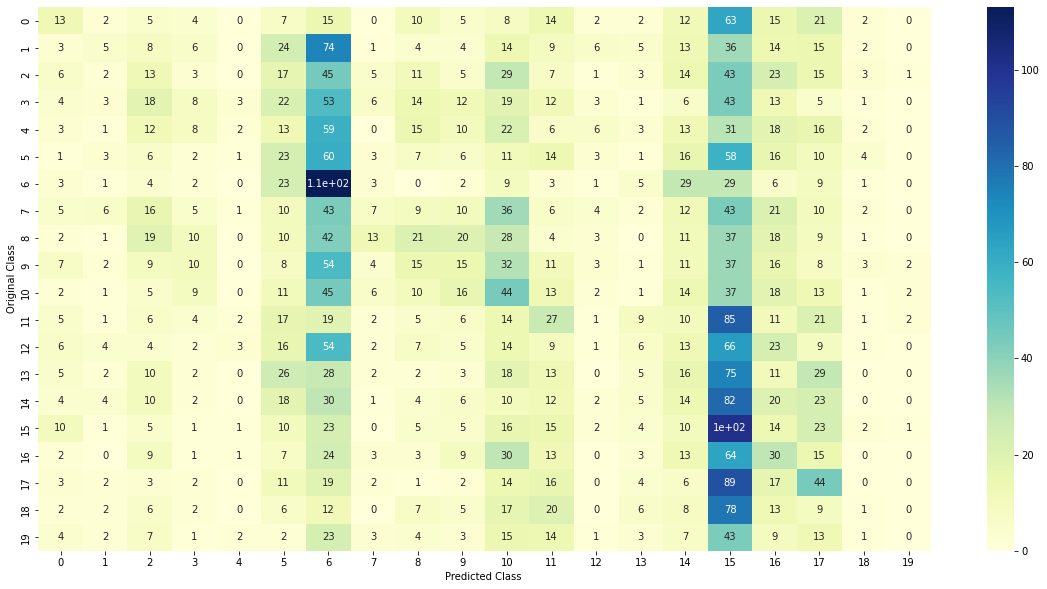

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(np.argmax(y_test_final,axis=1),np.argmax(evaluate,axis=1)),annot=True,cmap="YlGnBu")
plt.xlabel('Predicted Class ')
plt.ylabel('Original Class')